**Github for Blackjack Gym**: https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py

**On-policy First-visit MC control algorithm for epsilon-soft policies**

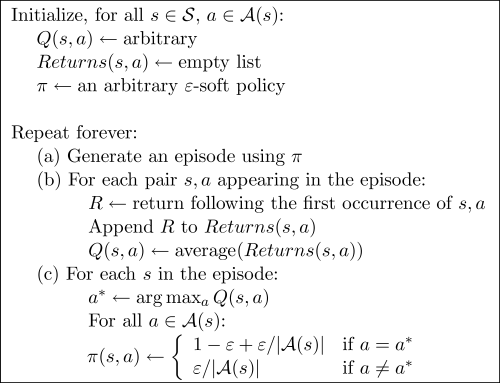

**The optimal policy and state value function for blackjack**

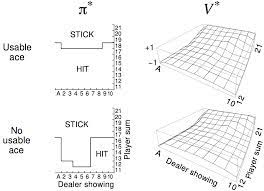

In [30]:
import gym
from gym import envs
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from matplotlib import cm
from collections import defaultdict
from IPython.display import clear_output
%matplotlib inline

In [31]:
env = gym.make('Blackjack-v0')

In [32]:
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

In [33]:
env.action_space.n

2

In [34]:
env.reset()

(16, 2, False)

In [35]:
env.step(1)

((25, 2, False), -1.0, True, {})

In [36]:
env.dealer

[2, 10]

In [37]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
def plot_policy(policy):

    def get_Z(player_hand, dealer_showing, usable_ace):
        if (player_hand, dealer_showing, usable_ace) in policy:
            return policy[player_hand, dealer_showing, usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(1, 11)
        y_range = np.arange(11, 22)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(player_hand, dealer_showing, usable_ace) for dealer_showing in x_range] for player_hand in range(21, 10, -1)])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 2), vmin=0, vmax=1, extent=[0.5, 10.5, 10.5, 21.5])
        plt.xticks(x_range, ('A', '2', '3', '4', '5', '6', '7', '8', '9', '10'))
        plt.yticks(y_range)
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Hand')
        ax.grid(color='black', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0, 1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
        cbar.ax.invert_yaxis() 
            
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace', fontsize=16)
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace', fontsize=16)
    get_figure(False, ax)
    plt.show()

In [38]:
def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(16,8))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

In [39]:
def create_epsilon_greedy_action_policy(env,Q,epsilon):
    """ Create epsilon greedy action policy
    Args:
        env: Environment
        Q: Q table
        epsilon: Probability of selecting random action instead of the 'optimal' action
    
    Returns:
        Epsilon-greedy-action Policy function with Probabilities of each action for each state
    """
    def policy(obs):
        P = np.ones(env.action_space.n, dtype=float) * epsilon / env.action_space.n  #initiate with same prob for all actions
        best_action = np.argmax(Q[obs])  #get best action
        P[best_action] += (1.0 - epsilon)
        return P
    return policy

In [40]:
def On_pol_mc_control_learn(env, episodes, discount_factor, epsilon):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: Environment.
        episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state to action values.
        Policy is the trained policy that returns action probabilities
    """
    # Keeps track of sum and count of returns for each state
    # An array could be used to save all returns but that's memory inefficient.
    # defaultdict used so that the default value is stated if the observation(key) is not found
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    pol = create_epsilon_greedy_action_policy(env,Q,epsilon)
    
    for i in range(1, episodes + 1):
        # Print out which episode we're on
        if i% 1000 == 0:
            print("\rEpisode {}/{}.".format(i, episodes), end="")
            clear_output(wait=True)

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            probs = pol(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all (state, action) pairs we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            #First Visit MC:
            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
    
    return Q, pol

In [48]:
env.reset()
Q_on_pol, On_MC_Learned_Policy = On_pol_mc_control_learn(env, 500000, 0.9, 0.05)

Episode 500000/500000.

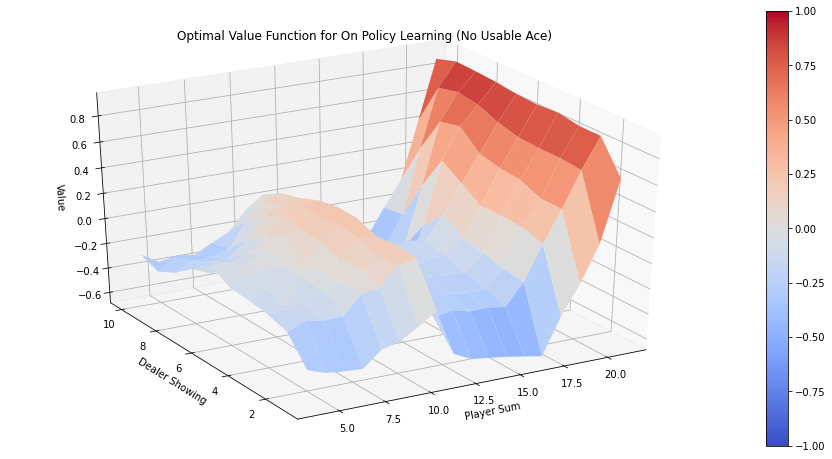

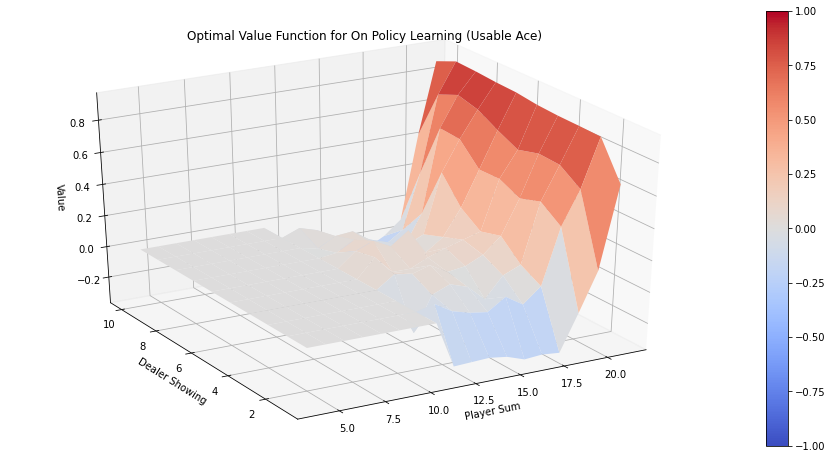

In [49]:
v = defaultdict(float)
for state, actions in Q_on_pol.items():
  action_value = np.max(actions)
  v[state] = action_value
plot_value_function(v, title="Optimal Value Function for On Policy Learning")

On-Policy MC Learning Policy


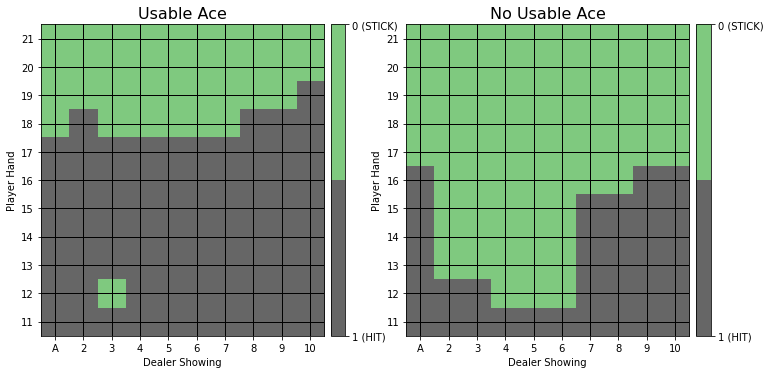

In [50]:
on_pol = {key:np.argmax(On_MC_Learned_Policy(key)) for key in Q_on_pol.keys()}
print("On-Policy MC Learning Policy")
plot_policy(on_pol)